In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool
from matplotlib.colors import LogNorm
from Loader import Loader

from PlotTool import PlotTool
from Cuts import qratio, getQAB, qlayerCut

savedir = '../plots/ehealert_updatedbaseline/'

In [2]:
# Load the data
L3 = C.basesel + '&&(ndoms_5pe > 120 && hs_q_tot_pulses > 3000 && ImpLF_rchi2 < 80)'
loader = Loader(L3)

# Instead of leading numu datasets together, keep them 
# separate. This is because when making the effective area
# plot we have to divide by the file normalizations to get
# the correct effective area.
he_numu = loader.getNuMuHE()
le_numu = loader.getNuMuLE()

In [3]:
# Apply the signal region cuts
xval = 'cos(ImpLF_zen)'
yval = 'log10(hs_q_tot_pulses)'
def getdata(dt, threshold, a, b):
    y = dt[yval]
    x = dt[xval]
    down = (x >= 0.1) & (y >= threshold + b * np.sqrt(1-np.power((x-a-0.1)/a,2)))
    up   = (x<0.1) & (y >= threshold)
    return dt[ down | up]

In [13]:
he_sig_numu = getdata(he_numu, 3.6, 0.83, 2.99)
le_sig_numu = getdata(le_numu, 3.6, 0.83, 2.99)

In [23]:
# Methods to plot effective area
from math import pi,log10

xmin  = 3
xmax  = 7
nbins = 20
ebins_per_decade = float(nbins/(xmax-xmin))
solidangle = 4*pi

def mcLogEBin(E):
    return int(log10(E)*ebins_per_decade)
def mcEMin(mc_log_ebin):
    return pow(10,mc_log_ebin/ebins_per_decade)
def mcEMax(mc_log_ebin):
    return pow(10,(1+mc_log_ebin)/ebins_per_decade)

# Calculate effective area
def getEffA(data, nfiles):
    effA = np.zeros(len(data['PrimaryNeutrinoEnergy']),dtype=float)
    energy = np.empty(len(data['PrimaryNeutrinoEnergy']),dtype=float)        
    fnorm  = 1. / nfiles
    
    dt_E = data['PrimaryNeutrinoEnergy'].as_matrix()
    dt_oneweight = data['OneWeight'].as_matrix()
    dt_nevents   = data['NEvents'].as_matrix()
    for i in range(len(effA)):

        E = dt_E[i]
        OneWeight = dt_oneweight[i]
        NEvents   = dt_nevents[i]
        mclogebin = mcLogEBin(E)
        mcemin = mcEMin(mclogebin)
        mcemax = mcEMax(mclogebin)
        
        effA[i] = 1e-4 * OneWeight * fnorm/NEvents * 1/(solidangle*(mcemax-mcemin))
        energy[i] = log10(E)

    return effA, energy

def plotEffA(nrg, effa, col, lbl,ls='solid'):
        plt.hist(nrg,
                 weights=effa,
                 color=col,
                 label=lbl,
                 range=(xmin,xmax),
                 bins = nbins,
                 histtype='step',
                 lw = 1.5,
                 ls = ls)

3.92823356064


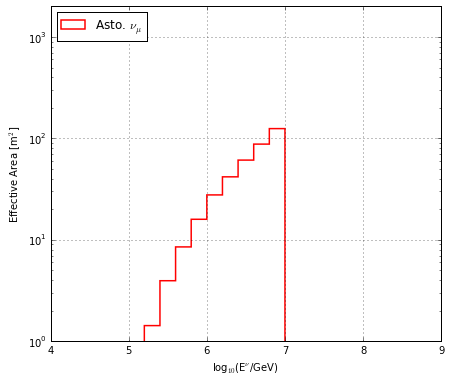

In [24]:
# Now plot the effective area for nu_e events from HESE
# and those passing the new BDT selection

# Get EFFA for high and low energy
he_effa, he_e = getEffA(he_sig_numu, C.nugen_henumu_nfiles)
le_effa, le_e = getEffA(le_sig_numu, C.nugen_numu_nfiles)
tot_effa = np.concatenate([he_effa,le_effa])
tot_e = np.concatenate([he_e,le_e])

print sum(he_sig_numu.wE2)*365/34.7 + sum(le_sig_numu.wE2)*365/34.7

# Now plot
fig,ax = plt.subplots(figsize=(7,6))
plotEffA(tot_e, tot_effa, 'r', r'Asto. $\nu_{\mu}$')


ax.set_ylim([1e0,2e3])
ax.set_xlim([4,9])
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(E$^{\nu}$/GeV)')
plt.ylabel(r'Effective Area [m$^{2}$]')
plt.grid()
plt.legend(loc='upper left')

#plt.savefig(savedir+'/EffectiveArea_numu.png')

In [27]:
# Save the effective area output in a pkl file to analyze later
h_effa, e_bins = np.histogram(tot_e, 
                              weights=tot_effa,
                              bins=nbins,
                              range=(xmin,xmax))

e_center = (e_bins[:-1]+e_bins[1:])/2.
print h_effa
print e_center

stuff = {'mu_effa_ehealert'   : h_effa,
         'mu_bins_ehealert'   : e_bins,
         'mu_cent_ehealert'   : e_center}

import pickle
pickle.dump(stuff, open('ehealert_numu_effa_Mar23.pkl','w'))

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.23798374e-03   7.06237428e-02   3.39584413e-01   1.42635542e+00
   3.95221971e+00   8.51373023e+00   1.59432900e+01   2.77194041e+01
   4.17942582e+01   6.11100136e+01   8.78510223e+01   1.24896864e+02]
[ 3.1  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7  5.9
  6.1  6.3  6.5  6.7  6.9]
